# Energy-limited mass loss

Exploring some ideas here

Vassapragada et al. 2022

In [11]:
import numpy as np
import astropy.units as u
import astropy.constants as const

## Compare potential and kinetic energy


$K = 1 - \frac{3}{2}\Big(\frac{R_\mathrm{p}}{R_\mathrm{Roche}}\Big) + \frac{1}{2}\Big(\frac{R_\mathrm{p}}{R_\mathrm{Roche}}\Big)^3$

In [3]:
rH_by_Rp = 2.731
Rp_by_rH = 1/rH_by_Rp

In [4]:
K = 1 - 3/2 *(Rp_by_rH) + 0.5 * (Rp_by_rH)**3

In [5]:
K

0.4752980071273514

What is the energy associated with **kinetic energy**?

In [21]:
v_gas = 30.0 * u.km/u.s

In [22]:
kinetic_energy_per_gram = 0.5*v_gas**2

In [23]:
kinetic_energy_per_gram.to(u.erg/u.gram)

<Quantity 4.5e+12 erg / g>

What is the energy associated with **potential energy**?

$$\dot{M}\Big(\frac{KGM_\mathrm{p}}{R_\mathrm{p}} + \frac{\Delta v^2}{2} + \frac{5}{2}\frac{k\Delta T}{\mu m_\mathrm{H}}\Big) = \iiint \limits \Gamma_\mathrm{net} dV$$

In [24]:
R_planet = 2.085 * u.R_jup
m_planet = (0.34 * u.Mjup).to(u.Msun)

In [25]:
potential_energy_per_gram = K * const.G * m_planet / R_planet
potential_energy_per_gram.to(u.erg/u.gram)

<Quantity 1.37344681e+12 erg / g>

In [26]:
(potential_energy_per_gram/kinetic_energy_per_gram).to(u.dimensionless_unscaled)

<Quantity 0.3052104>

In [4]:
R_star = 2.546 * u.Rsun
M_star = 1.642 * u.Msun
a_by_R_star = 5.691 
a_AU = (a_by_R_star * R_star).to(u.AU)


In [6]:
r_Hill = a_AU * (m_planet/(3*M_star))**(1/3)

In [7]:
rH_by_Rp = (r_Hill/R_planet).to(u.dimensionless_unscaled)
rH_by_a = (r_Hill/a_AU).to(u.dimensionless_unscaled)

In [8]:
rH_by_Rp, rH_by_a

(<Quantity 2.73132421>, <Quantity 0.04038943>)

So the Hill radius is $\sim$2.7 planetary radii, which is about 4% of the way towards the star.

In [9]:
star_to_planet_radius_ratio = (R_star/R_planet).to(u.dimensionless_unscaled)

In [10]:
1/(R_star/r_Hill).to(u.dimensionless_unscaled)

<Quantity 0.22985627>

In [11]:
1/(R_star/r_Hill).to(u.dimensionless_unscaled)**2

<Quantity 0.05283391>

The star is almost 12 times longer than the planet, so the Hill radius is only about 20% of a stellar radius.  So when the planet is transiting, the projected hill sphere covers about 5% of the stellar disk.  

We observed gas much farther away than the Hill sphere.  

### Plot the potential contours with `gala`

In [12]:
%config InlineBackend.figure_format='retina'

In [13]:
import matplotlib.pyplot as plt
import gala.potential as gp
from gala.units import solarsystem

## Try the solar system first

In [14]:
import gala.dynamics as gd

In [15]:
pot = gp.KeplerPotential(m=1.0*u.Msun, units=solarsystem)

In [16]:
earth_speed = (2*np.pi*u.AU / (365.25*u.day)).to(u.km/u.s).value

In [17]:
w0 = gd.PhaseSpacePosition(pos=[1.0, 0., 0.]*u.AU,
                            vel=[0, earth_speed, 0]*u.km/u.s)

In [18]:
orbit = gp.Hamiltonian(pot).integrate_orbit(w0, dt=0.360*u.day, n_steps=1000)

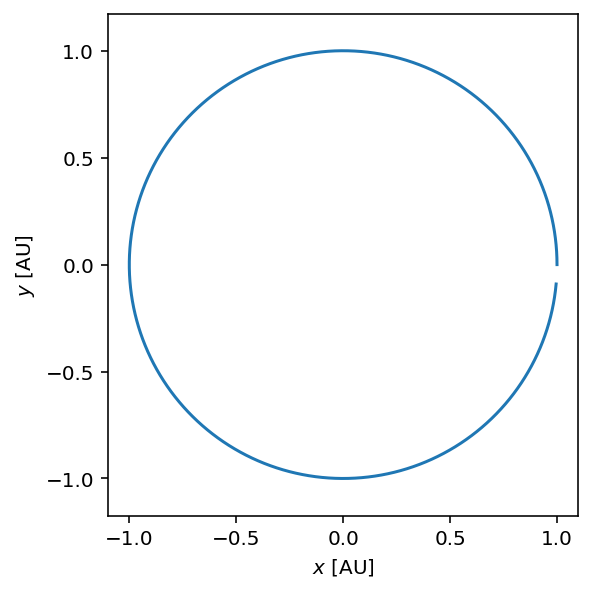

In [19]:
fig = orbit.plot(components=['x', 'y'])

Looks good!

### Now try composite

In [20]:
star_origin = (0.0, 0.0, 0.0) #(0.0*u.AU, 0.0*u.AU, 0.0*u.AU)
ptmass = gp.KeplerPotential(m=M_star, units=solarsystem, origin=star_origin)

In [21]:
M_star

<Quantity 1.642 solMass>

In [22]:
planet_origin = (a_AU.value, 0.0, 0.0)
ptmass_planet = gp.KeplerPotential(m=m_planet, units=solarsystem, origin=planet_origin)

In [23]:
system = ptmass + ptmass_planet

In [24]:
system

<CompositePotential 4f28e9d2-3e27-44ed-aa2f-5a35b8fc2358,591bec14-e403-4fef-9b68-ed3a5fe35e8d>

In [25]:
w0 = gd.PhaseSpacePosition(pos=[0.066, 0., 0.]*u.AU,
                            vel=[0, 10.0, 0]*u.km/u.s)

In [26]:
orbit = gp.Hamiltonian(system).integrate_orbit(w0, dt=20*u.second, n_steps=1000)

In [27]:
system.__class__.__name__

'CCompositePotential'

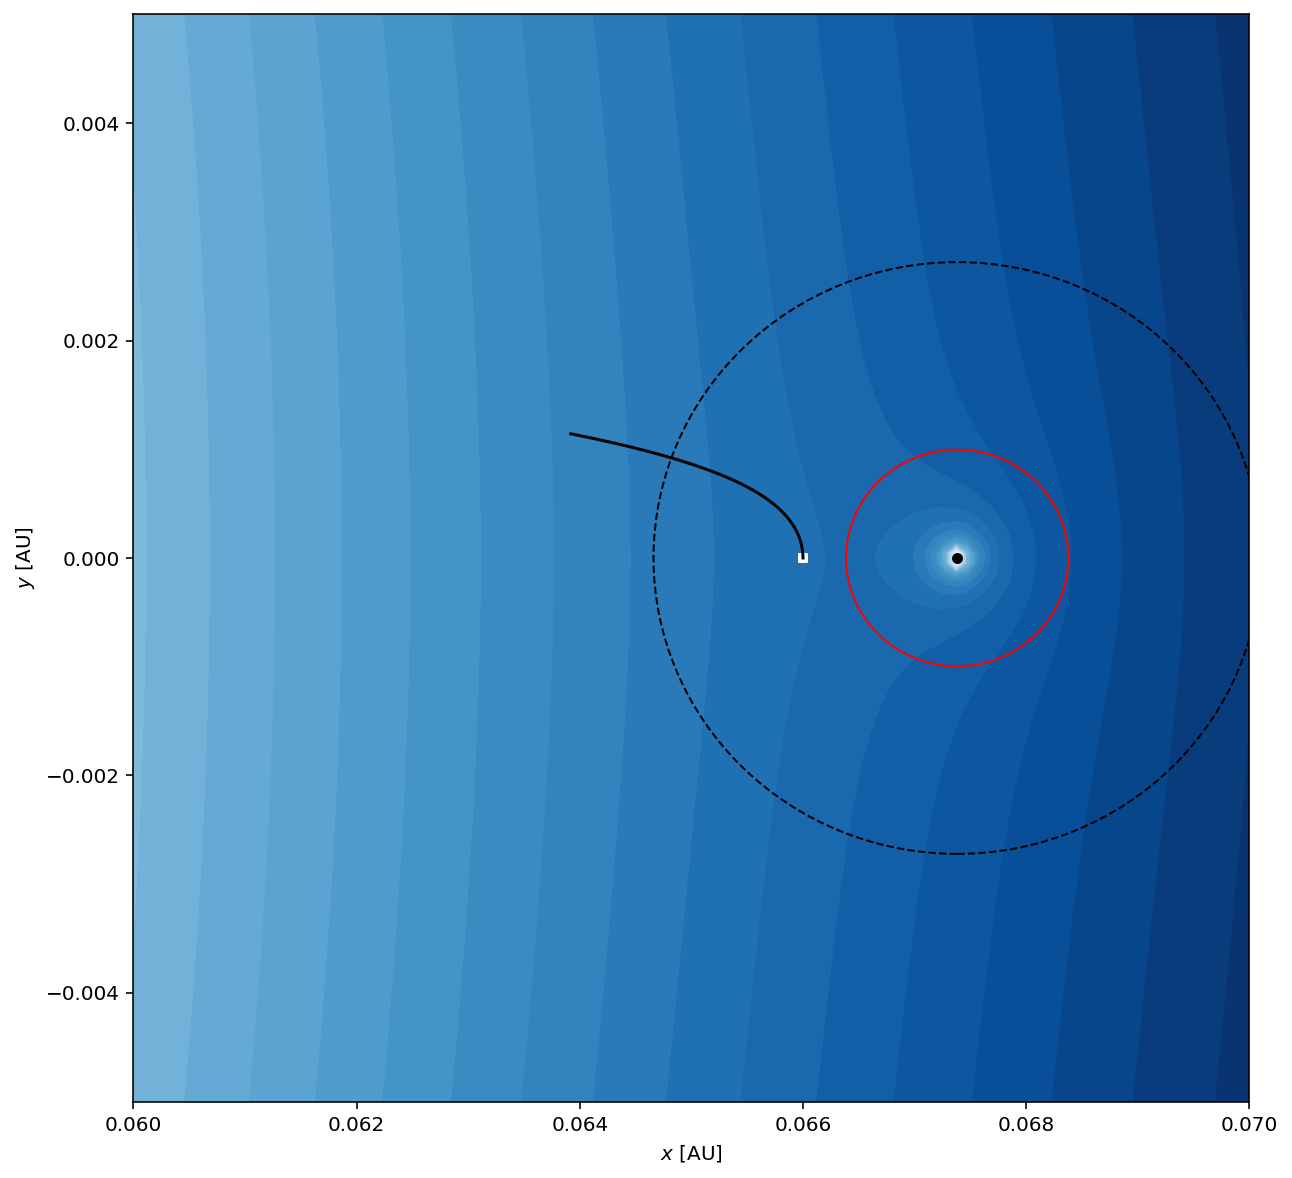

In [28]:
circle1 = plt.Circle((a_AU.value, 0), radius=R_planet.to(u.AU).value, color='r', fill=False)
hill_circle = plt.Circle((a_AU.value, 0), radius=r_Hill.to(u.AU).value, color='k', 
                         fill=False, clip_on=True, linestyle='dashed')

fig,ax = plt.subplots(1, 1, figsize=(10, 10))
x_grid = np.linspace(0.06, 0.07, 100)
y_grid = np.linspace(-0.005, 0.005, 100)
system.plot_contours(grid=(x_grid, y_grid, 0), ax=ax, levels=30)

ax.scatter([0.066], [0.0], marker='s', s=20, color='w')
ax.scatter([a_AU.value], [0.0], marker='o', s=20, color='k')

ax.plot(orbit.x.value, orbit.y.value, color='k')

ax.add_patch(circle1)
ax.add_patch(hill_circle)

ax.set_xlim(0.06, 0.07)
ax.set_ylim(-0.005, 0.005)
ax.set_xlabel("$x$ [AU]") 
ax.set_ylabel("$y$ [AU]");

Neat! The potential does not match the calculated Hill sphere because we are not including the angular momentum of the planet.

###  N-body simulations

In [29]:
from gala.dynamics.nbody import DirectNBody

In [30]:
speed = (2*np.pi*a_AU/(4.8*u.day)).to(u.km/u.s).value

In [31]:
speed

152.7192831269461

In [32]:
a_AU

<Quantity 0.06738195 AU>

In [33]:
r_Hill

<Quantity 0.00272152 AU>

In [34]:
r_Hill

<Quantity 0.00272152 AU>

In [35]:
w0_1 = gd.PhaseSpacePosition(pos=[a_AU.value, 0, 0] * u.AU,
                              vel=[0, speed, 0] * u.km/u.s)
w0_2 = gd.PhaseSpacePosition(pos=w0_1.xyz + [-0.9*r_Hill.to(u.AU).value, 0, 0]*u.AU,
                              vel=w0_1.v_xyz + [0, 0.1, 0] * u.km/u.s)

In [36]:
w0 = gd.combine((w0_1, w0_2))

In [37]:
particle_pot = [ptmass_planet, None]
nbody = DirectNBody(w0, particle_pot, external_potential=ptmass)

In [38]:
orbits = nbody.integrate_orbit(dt=10*u.second, t1=0, t2=20*u.day)

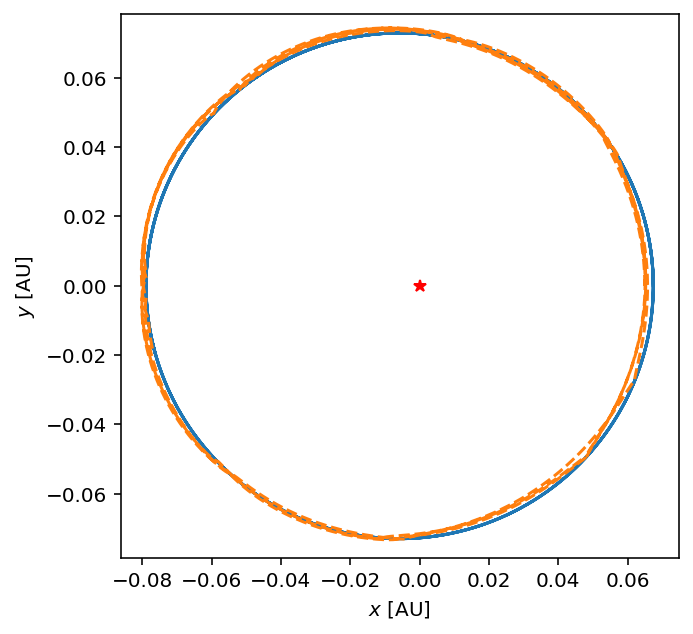

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 
_ = orbits[:, 0].plot(['x', 'y'], axes=[ax]) 
_ = orbits[:, 1].plot(['x', 'y'], axes=[ax], linestyle='dashed') 
plt.plot([0], [0], 'r*')

(-0.1, 0.1)

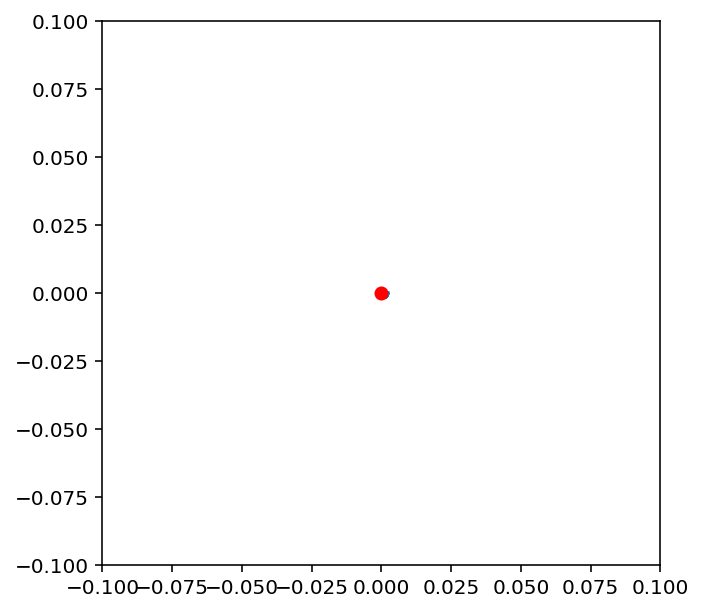

In [40]:
dxyz = orbits[:, 0].xyz - orbits[:, 1].xyz
fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 
ax.plot(dxyz[0], dxyz[1]) 
plt.plot([0], [0], 'ro')
planet = plt.Circle((0, 0), radius=R_planet.to(u.AU).value, color='r', fill=True)
ax.add_artist(planet)
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)

Indeed! At 90% the hill radius, we see that the test particle stays bound to the planet.

At 110% of the hill radius, we see the test particle become bound to the star.  Neat!